In [36]:
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.preprocessing import StandardScaler

In [37]:
# Preprocess the Data: from naivebayes2 (Melvin Adkins work)

lemmatizer = WordNetLemmatizer()


# Read in hand labeled data
filepath = "df_ver_combined_hand-labels.csv"
hand_label = "hand_label"
government = "['government']"
academia = "['academia']"

df = pd.read_csv(filepath, nrows=235) # reads in hand labeled data
df = df[((df[hand_label]=="['media']") | (df[hand_label]==academia) | (df[hand_label]==government) | (df[hand_label]=="['other']"))] # use single labels
df = df[['username','description',hand_label]] # keep only relevant columns

"""
filepath = "finalized_8K_accounts.csv"
hand_label = "hand.label"
government = "gov"
academia = "acad"

df = pd.read_csv(filepath)

df = df[((df[hand_label]=='media') | (df[hand_label]== academia) | (df[hand_label]==government) | (df[hand_label]=='other' ))]


df = df[['username','description',hand_label]] # keep only relevant columns
"""

# Preprocessing step - lemmatization on description column
words_not_changed = ['media']
def preprocessing(row):
    row = str(row).lower()          # lowercase (so that upper and lowercase words are treated the same)
    row = word_tokenize(row)   # tokenize  (to perform lemmitization)
    row = [lemmatizer.lemmatize(word) if word not in words_not_changed else word for word in row]   # lemmatize
    return str(row)            # convert back to string


df['description_lemmatized'] = df['description'].apply(preprocessing)


print(df.head())
print()

print(df.head())
print()
print('Number of labels per category:')
print(df[hand_label].value_counts())
print()

          username                                        description  \
0      annenbcnews  Chief Environmental Affairs Correspondent, NBC...   
1            USFSM  The official Twitter account for the Universit...   
2   KMillerWeather  Real estate and growth reporter for The Palm B...   
4  WhySharksMatter  Research associate at @ASU @ASUinDC studying s...   
5      Casper30214  Army Civil Service(Retired);Military Ops Resea...   

     hand_label                             description_lemmatized  
0     ['media']  ['chief', 'environmental', 'affair', 'correspo...  
1  ['academia']  ['the', 'official', 'twitter', 'account', 'for...  
2     ['media']  ['real', 'estate', 'and', 'growth', 'reporter'...  
4  ['academia']  ['research', 'associate', 'at', '@', 'asu', '@...  
5     ['other']  ['army', 'civil', 'service', '(', 'retired', '...  

          username                                        description  \
0      annenbcnews  Chief Environmental Affairs Correspondent, NBC...   


In [38]:
# split my data into training, and test sets
scaler = StandardScaler()

X = df['description_lemmatized']
y_labels = df[hand_label]

X_train, X_test, y_train, y_test = train_test_split(X, y_labels, test_size=0.2, random_state=42, stratify=y_labels)

In [39]:
print("SHAPE:", X_train.shape)

SHAPE: (185,)


In [40]:
print(y_train.value_counts())

['media']         132
['government']     26
['other']          21
['academia']        6
Name: hand_label, dtype: int64


In [41]:
print(y_test.value_counts())

['media']         34
['government']     6
['other']          5
['academia']       2
Name: hand_label, dtype: int64


# TF-IDF Vectors as Numerical representation

In [42]:
tfidf_transformer = TfidfTransformer()
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.015)


tfidf_pipeline = Pipeline([
    ('vectorizer', count_vectorizer),
    ('transformer', tfidf_transformer),
    ('normalize', StandardScaler()),
    ('classifier', SVC())
])

tfidf_param_grid = [
    {
        'vectorizer__min_df': [0, 0.01, 0.03, 0.05, 0.10, 0.15, 0.20],
        'transformer__use_idf': [True, False],
        'normalize__with_mean': [False],
        'classifier__C': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    }
]

### Bag of Words as Numerical Representation

In [43]:
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.015)

bag_of_words_pipeline = Pipeline([
    ('vectorizer', count_vectorizer),
    ('normalize', StandardScaler()),
    ('classifier', SVC())
])

bag_of_words_param_grid = [
    {
        'vectorizer__min_df': [0, 0.01, 0.03, 0.05, 0.10, 0.15, 0.20],
        'normalize__with_mean': [False],
        'classifier__C': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed']
    }
]


In [44]:
# Grid Search - TF-IDF
tfidf_grid_search = GridSearchCV(estimator=tfidf_pipeline, param_grid=tfidf_param_grid, cv=5, scoring='accuracy', verbose=1)

tfidf_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 350 candidates, totalling 1750 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
550 fits failed out of a total of 1750.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
250 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/li

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(min_df=0.015,
                                                        stop_words='english')),
                                       ('transformer', TfidfTransformer()),
                                       ('normalize', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': [1e-10, 0.5, 2.0, 5.0, 10.0],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid', 'precomputed'],
                          'normalize__with_mean': [False],
                          'transformer__use_idf': [True, False],
                          'vectorizer__min_df': [0, 0.01, 0.03, 0.05, 0.1, 0.15,
                                                 0.2]}],
             scoring='accuracy', verbose=1)

In [45]:
# Bag Of Words
bag_of_words_grid_search = GridSearchCV(estimator=bag_of_words_pipeline, param_grid=bag_of_words_param_grid, cv=5, scoring='accuracy', verbose=1)

bag_of_words_grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 175 candidates, totalling 875 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
275 fits failed out of a total of 875.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
125 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vectorizer',
                                        CountVectorizer(min_df=0.015,
                                                        stop_words='english')),
                                       ('normalize', StandardScaler()),
                                       ('classifier', SVC())]),
             param_grid=[{'classifier__C': [1e-10, 0.5, 2.0, 5.0, 10.0],
                          'classifier__kernel': ['linear', 'poly', 'rbf',
                                                 'sigmoid', 'precomputed'],
                          'normalize__with_mean': [False],
                          'vectorizer__min_df': [0, 0.01, 0.03, 0.05, 0.1, 0.15,
                                                 0.2]}],
             scoring='accuracy', verbose=1)

In [50]:
tfidf_best_hyperparameters = tfidf_grid_search.best_params_
print("Best TF-IDF SVM ACCURACY:", tfidf_grid_search.best_score_)
print("Best TF-IDF SVM Hyperparameters:", tfidf_best_hyperparameters)

print()

Best TF-IDF SVM ACCURACY: 0.8216216216216218
Best TF-IDF SVM Hyperparameters: {'classifier__C': 2.0, 'classifier__kernel': 'sigmoid', 'normalize__with_mean': False, 'transformer__use_idf': False, 'vectorizer__min_df': 0.01}



In [52]:
bag_of_words_best_hyperparameters = bag_of_words_grid_search.best_params_
print("Best TF-IDF Bag of Words ACCURACY:", bag_of_words_grid_search.best_score_)
print("Best TF-IDF Bag of Words Hyperparameters:", bag_of_words_best_hyperparameters)

print()

Best TF-IDF Bag of Words ACCURACY: 0.8
Best TF-IDF Bag of Words Hyperparameters: {'classifier__C': 2.0, 'classifier__kernel': 'sigmoid', 'normalize__with_mean': False, 'vectorizer__min_df': 0.01}



In [53]:
tfidf_best_SVM_model = tfidf_grid_search.best_estimator_

In [54]:
bag_of_words_best_SVM_model = bag_of_words_grid_search.best_estimator_

In [55]:
tfidf_pipeline.set_params(**tfidf_grid_search.best_params_)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.01, stop_words='english')),
                ('transformer', TfidfTransformer(use_idf=False)),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier', SVC(C=2.0, kernel='sigmoid'))])

In [56]:
bag_of_words_pipeline.set_params(**bag_of_words_grid_search.best_params_)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.01, stop_words='english')),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier', SVC(C=2.0, kernel='sigmoid'))])

In [57]:
tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.01, stop_words='english')),
                ('transformer', TfidfTransformer(use_idf=False)),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier', SVC(C=2.0, kernel='sigmoid'))])

In [58]:
bag_of_words_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.01, stop_words='english')),
                ('normalize', StandardScaler(with_mean=False)),
                ('classifier', SVC(C=2.0, kernel='sigmoid'))])

In [59]:
# Cross validate
y_pred_tfidf = cross_val_predict(tfidf_best_SVM_model, X_train, y_train, cv=5)

In [60]:
y_pred_bag_of_words = cross_val_predict(bag_of_words_best_SVM_model, X_train, y_train, cv=5)


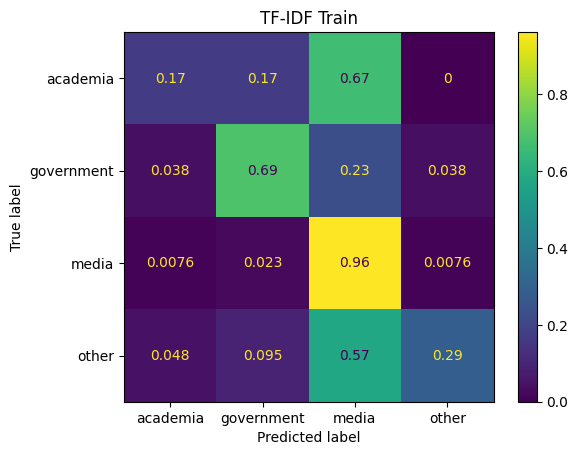

In [61]:
cm = confusion_matrix(y_train, y_pred_tfidf, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("TF-IDF Train")
plt.show()

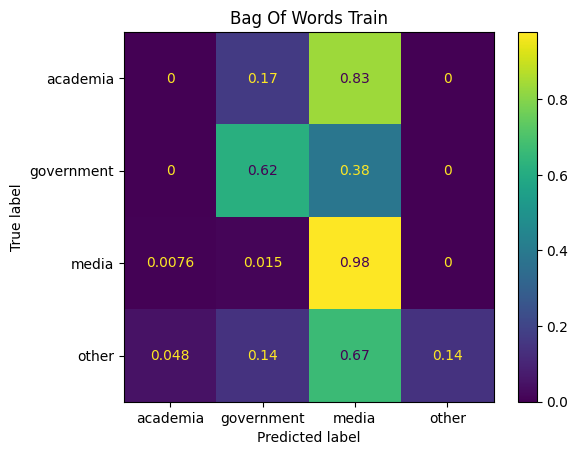

In [62]:
cm = confusion_matrix(y_train, y_pred_bag_of_words, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("Bag Of Words Train")
plt.show()

In [63]:
print("TF-IDF Classification Report:")
print(metrics.classification_report(y_train, y_pred_tfidf))

TF-IDF Classification Report:
                precision    recall  f1-score   support

  ['academia']       0.25      0.17      0.20         6
['government']       0.75      0.69      0.72        26
     ['media']       0.85      0.96      0.90       132
     ['other']       0.75      0.29      0.41        21

      accuracy                           0.82       185
     macro avg       0.65      0.53      0.56       185
  weighted avg       0.81      0.82      0.80       185



In [64]:
print("Bag of Words Classification Report:")
print(metrics.classification_report(y_train, y_pred_bag_of_words))

Bag of Words Classification Report:
                precision    recall  f1-score   support

  ['academia']       0.00      0.00      0.00         6
['government']       0.73      0.62      0.67        26
     ['media']       0.82      0.98      0.89       132
     ['other']       1.00      0.14      0.25        21

      accuracy                           0.80       185
     macro avg       0.64      0.43      0.45       185
  weighted avg       0.80      0.80      0.76       185



### Fit models to the feature set and evaluate performance


In [65]:
tfidf_y_pred_test = tfidf_pipeline.predict(X_test)

In [66]:
bag_of_words_y_pred_test = bag_of_words_pipeline.predict(X_test)

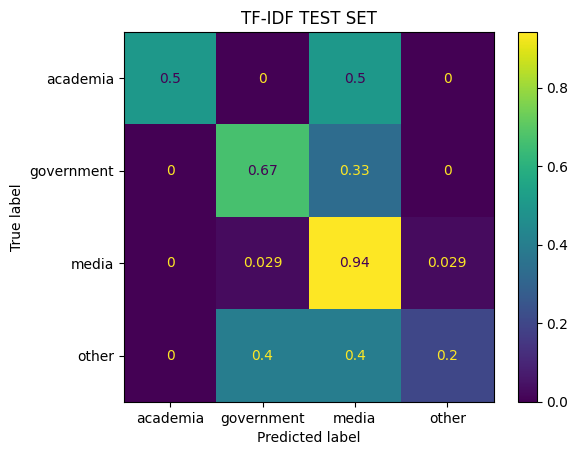

In [67]:
cm = confusion_matrix(y_test, tfidf_y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("TF-IDF TEST SET")
plt.show()

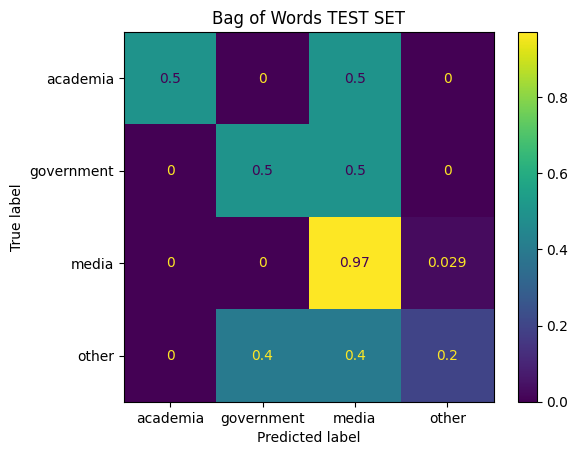

In [68]:
cm = confusion_matrix(y_test, bag_of_words_y_pred_test, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['academia', 'government', 'media', 'other'])
disp.plot()

plt.title("Bag of Words TEST SET")
plt.show()

In [69]:
print("TF-IDF Classification Report TEST:")
print(metrics.classification_report(y_test, tfidf_y_pred_test))
print()

TF-IDF Classification Report TEST:
                precision    recall  f1-score   support

  ['academia']       1.00      0.50      0.67         2
['government']       0.57      0.67      0.62         6
     ['media']       0.86      0.94      0.90        34
     ['other']       0.50      0.20      0.29         5

      accuracy                           0.81        47
     macro avg       0.73      0.58      0.62        47
  weighted avg       0.79      0.81      0.79        47




In [70]:
print("Bag of Words Classification Report TEST:")
print(metrics.classification_report(y_test, bag_of_words_y_pred_test))
print()

Bag of Words Classification Report TEST:
                precision    recall  f1-score   support

  ['academia']       1.00      0.50      0.67         2
['government']       0.60      0.50      0.55         6
     ['media']       0.85      0.97      0.90        34
     ['other']       0.50      0.20      0.29         5

      accuracy                           0.81        47
     macro avg       0.74      0.54      0.60        47
  weighted avg       0.78      0.81      0.78        47


